In [86]:
import torch
import jieba
import random

import numpy as np
import pandas as pd

from data import Data
from torch import nn, optim
from datetime import datetime
from torchsummary import summary
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [87]:
# Set random seed.
random_seed = 0

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [88]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda:0"

print(device)

cuda:0


In [89]:
classes = {
    0: "牡羊",
    1: "金牛",
    2: "雙子",
    3: "巨蠍",
    4: "獅子",
    5: "處女",
    6: "天秤",
    7: "天蠍",
    8: "射手",
    9: "魔羯",
    10: "水瓶",
    11: "雙魚",
}

In [90]:
raw = {i: open(f"./dataset/{classes[i]}.txt", encoding="utf-8").read() for i in range(12)}
data = Data(data=raw, padding_length=32)

train_raw = data.get("data")

Cleaning completed.
ToDataset completed.
Argumantation completed.
Tokenlization completed.
Padding completed.
Token2id completed.
Process completed.


In [91]:
len(train_raw)

3528

In [92]:
train_raw[0]

[[2038,
  704,
  973,
  3293,
  1568,
  2405,
  2212,
  1229,
  1632,
  2361,
  2680,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331,
  2331],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [93]:
class CreateDataset(Dataset):
    def __init__(self, data: list, label: list):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        return torch.tensor(self.data[index]), torch.tensor(self.label[index], dtype=torch.float)

    def __len__(self):
        return len(self.label)

In [94]:
d, l = [], []

for i, j in train_raw:
    d.append(i); l.append(j)

train_ds = CreateDataset(d, l)

In [95]:
train_ds[1]

(tensor([2038,  704,  973, 3293, 1568, 2405, 2212, 1229, 1632, 2361, 2680, 2331,
         2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331,
         2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [96]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

In [97]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.embedding = nn.Embedding(data.get("token_len"), 64)
        self.lstm = nn.LSTM(input_size=64, hidden_size=256, num_layers=4, dropout=0.5, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(16384, 12)

    def forward(self, x: torch.Tensor):
        x = self.embedding(x)
        x, _ = self.lstm(x)

        x = x.reshape(x.size()[0], -1)

        x = self.linear(x)

        return x

In [98]:
model = Model().to(device=device)

In [99]:
epochs = 10
optimizer = optim.SGD(model.parameters())
loss = nn.CrossEntropyLoss()

In [100]:
# Traning history data.
train_accuracy_h = []
train_loss_h = []
validate_accuracy_h = []

In [101]:
def train(epochs: int, model: nn.Module, optimizer: optim.Optimizer, loss: nn.CrossEntropyLoss, dataloader: DataLoader):
    for epoch in range(epochs):
        # Set model to training mode.
        model.train()

        train_accuracy = 0
        train_loss = 0
        train_total = 0
        train_process = 0
        train_time = datetime.now().timestamp()

        for texts, labels in dataloader:
            texts: torch.Tensor
            labels: torch.Tensor

            texts = texts.to(device)
            labels = labels.to(device)

            outputs: torch.Tensor = model(texts)
            losses: torch.Tensor = loss(outputs, labels)

            # optimizer.zero_grad()
            for param in model.parameters(): param.grad = None

            # Backpropagation.
            losses.backward()

            # Update parameters.
            optimizer.step()

            _, predict = torch.max(outputs, 1)
            train_accuracy += sum([labels[i][predict[i]] == 1 for i in range(len(predict))])
            train_loss += losses.item()
            train_total += labels.shape[0]
            train_process += 1

            print(
                f"{datetime.now().strftime('%Y/%m/%d %H:%M:%S')} "
                f"Epoch: {epoch:03d} "
                f"Time: {datetime.now().timestamp() - train_time:.2f} "
                f"Process: {train_process / len(dataloader) * 100:.2f}% "
                f"Accuracy: {train_accuracy / train_total * 100:.2f}% "
                f"Loss: {train_loss:.3f}",
                end="\r"
            )

        train_accuracy_h.append(train_accuracy / train_total * 100)
        train_loss_h.append(train_loss)

        print()

        # Early stop.
        if train_accuracy / train_total > 99.99:
            print("Early stopped.")
            break

In [102]:
train(epochs=epochs, model=model, optimizer=optimizer, loss=loss, dataloader=train_dl)

2024/03/27 14:24:12 Epoch: 000 Time: 10.30 Process: 100.00% Accuracy: 15.56% Loss: 1051.329
2024/03/27 14:24:22 Epoch: 001 Time: 10.12 Process: 100.00% Accuracy: 17.55% Loss: 1035.901
2024/03/27 14:24:32 Epoch: 002 Time: 9.97 Process: 100.00% Accuracy: 20.61% Loss: 1011.878
2024/03/27 14:24:42 Epoch: 003 Time: 10.07 Process: 100.00% Accuracy: 26.96% Loss: 950.809
2024/03/27 14:24:52 Epoch: 004 Time: 9.90 Process: 100.00% Accuracy: 36.51% Loss: 866.718
2024/03/27 14:25:02 Epoch: 005 Time: 10.22 Process: 100.00% Accuracy: 45.80% Loss: 752.545
2024/03/27 14:25:12 Epoch: 006 Time: 10.05 Process: 100.00% Accuracy: 55.73% Loss: 624.405
2024/03/27 14:25:22 Epoch: 007 Time: 9.70 Process: 100.00% Accuracy: 65.96% Loss: 471.245
2024/03/27 14:25:32 Epoch: 008 Time: 9.76 Process: 100.00% Accuracy: 77.61% Loss: 323.372
2024/03/27 14:25:41 Epoch: 009 Time: 9.53 Process: 100.00% Accuracy: 85.06% Loss: 212.717


In [103]:
for i, j in train_dl:
    print(i)
    print(model(i.to(device)))
    print(j)
    break

tensor([[3205, 1803,  451, 1091, 1119, 2464, 1735, 2044, 2747, 2680, 2331, 2331,
         2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331,
         2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331],
        [ 105, 1015, 1226,   56, 1119, 1975,  690, 1632, 2459, 2680, 2331, 2331,
         2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331,
         2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331],
        [1688,  240,  344, 2840, 2932, 3066, 2680, 2331, 2331, 2331, 2331, 2331,
         2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331,
         2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331],
        [ 470, 3373,  704, 2932,  207, 3172, 2978, 1538, 1269, 3279, 1054,  379,
         1421, 1632,  973, 2361, 2680, 2331, 2331, 2331, 2331, 2331, 2331, 2331,
         2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331],
        [1964,  642, 1429, 1119, 1534, 1777, 3295,  662, 1119, 2793, 1595, 2190,
         1060,  728, 1485, 1069, 1632, 

In [194]:
test = "大方，性急"
temp = list(jieba.cut(test))
temp = temp + ["<PAD>"] * (32 - len(temp))
test = [data.w2i[x] if x in data.w2i else data.w2i["<PAD>"] for x in temp][:32]
print(test)

[2979, 1119, 3060, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331, 2331]


In [195]:
test = torch.tensor([test])

In [196]:
model.eval()

Model(
  (embedding): Embedding(3637, 64)
  (lstm): LSTM(64, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=16384, out_features=12, bias=True)
)

In [197]:
result = model(test.to(device)).tolist()[0]
print(result)

In [198]:
# Normolization
result = [x - min(result) for x in result]
result = [x / max(result) for x in result]
result = [round(x, 3) for x in result]

print(result)

[1.0, 0.767, 0.0, 0.64, 0.203, 0.202, 0.495, 0.71, 0.385, 0.322, 0.467, 0.204]


In [199]:
classes[int(torch.argmax(torch.tensor(result)))]

'牡羊'

In [200]:
classes

{0: '牡羊',
 1: '金牛',
 2: '雙子',
 3: '巨蠍',
 4: '獅子',
 5: '處女',
 6: '天秤',
 7: '天蠍',
 8: '射手',
 9: '魔羯',
 10: '水瓶',
 11: '雙魚'}

In [201]:
import matplotlib.pyplot as plt
import numpy as np

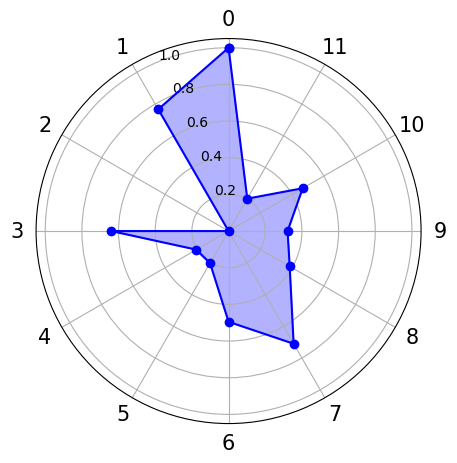

In [202]:
angles_A = np.linspace(start=0, stop=2*np.pi, num=len(result)+1, endpoint=True)
values_A = np.concatenate((result, [result[0]]))

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': 'polar'})
ax.plot(angles_A, values_A, 'o-', color="blue", label="A")

ax.fill(angles_A, values_A, alpha=0.3, color="blue")
ax.set_thetagrids(angles_A[:-1] * 180 / np.pi, range(12), fontsize=15)
ax.set_theta_zero_location('N')